# Solución ecuación de Schrodinger para un potencial cuadrado

A continuación, se presenta el código empleado para hallar la solución del problema que se nos propone, resolver la ecuación de Schrodinger unidimensional para un potencial cuadrado. Para ello se ha seguido el algoritmo dado en teoría, el cual se ha desglosado en las distintas celdas del código.

### Fundamento

Para resolver este problema, partimos de discretizar el espacio y el tiempo en la solución formal de la ecuación de Schrodinger:

$\Phi(x,t) \;=\; e^{-i\,(t - t_{0})\,H}\,\Phi(x,t_{0})$

tomando $x_j = j\,h, \quad t_n = n\,s, \quad j = 0,1,\dots,N,\quad n = 0,1,2,\dots$ donde $h$ es el espaciamiento en la discretización espacial y $s$ es el espaciamiento temporal.

La función de onda viene dada en cada punto del retículo espacio–temporal por
    
$\Phi(x_j, t_n) \;\longrightarrow\; \Phi(jh, ns) = \Phi_{j,n},
      \quad j = 0,1,\dots,N,\quad n = 0,1,2,\dots$

Supondremos que las condiciones de contorno para la función de onda en $j=0$ y $j=N$ son las correspondientes a la existencia de un potencial infinito en esos puntos; es decir, la densidad de probabilidad de encontrar la partícula allí es cero. Así, $\Phi_{0,n} = \Phi_{N,n} = 0,$ en cualquier instante.

Puede definirse de forma inmediata un primer algoritmo a partir de la expresión
    
$\Phi_{j,n+1} = e^{-\,i\,s\,H}\,\Phi_{j,n}$

Para poder simplificar el término exponencial, manteniendo un operador unitario, se emplea la aproximación de Cayley que, en resumidas cuentas, proporciona la siguiente solución

$\Phi_{j,n+1} = \bigl[\tfrac{2}{1 + i\,s\,H_{D}/2} - 1\bigr]\,\Phi_{j,n} = \chi_{j,n} - \Phi_{j,n}$

Podremos encontrar $\chi_{j,n}$  resolver un conjunto de ecuaciones del tipo

$
A_j^- \,\chi_{j-1,n}
\;+\;
A_j^0 \,\chi_{j,n}
\;+\;
A_j^+ \,\chi_{j+1,n}
\;=\;
b_{j,n},
\quad
j = 1,\dots,N-1
$

donde $ A_j^- = 1,\quad A_j^0 = -2 + \frac{2i}{\tilde s} - \tilde V_j,\quad A_j^+ = 1,$ y $ b_{j,n} = \frac{4i\,\Phi_{j,n}}{\tilde s}$, con $\tilde s = s/h^2$ y $\tilde V_j = h^2V_j$.

Para resolver la recurrencia anterior supondemos una solución del tipo
    
$\chi_{j+1,n} \;=\; \alpha_j \,\chi_{j,n} \;+\; \beta_{j,n}, \qquad j = 0,\dots,N-1$

donde, para garantizar que se cumple $\chi_{N,n}=0$, tomaremos $\alpha_{N-1} = \beta_{N-1,n} = 0$.

A continuación, podremos definir las recurrencias para los coeficientes $\alpha$ y $\beta$ así:

$\alpha_{j-1} = -A_j^- \,\gamma_j, \qquad \beta_{j-1,n} = \gamma_j\bigl(b_{j,n} - A_j^+\,\beta_{j,n}\bigr),$
    
donde $\gamma_j^{-1} = A_j^0 + A_j^+ \,\alpha_j$.

Conocida $\chi_{j,n}$, y con ella $\Phi_{j,n+1}$, necesitamos definir la función de onda inicial y con el potencial que actuará. Para ello, tomamos una onda plana con amplitud gaussiana, véase,

$\Phi(x,0) = e^{\,i k_0 x}\,e^{-\,(x - x_0)^2 / (2\sigma^2)}$

centrada en $x_0$ y de anchura $\sigma$. Estos parámetros se pueden tomar en función de $N$ y $n_{ciclos}$, $x_0 = Nh/4, \sigma = Nh/16 , k_0 = 2 \pi n_{ciclos} / N h$. Por último, el potencial propuesto tendrá anchura $N/5$, estará centrado en $N/2$ y su altura será proporcional a la energía de la onda incidente:

$\tilde V_j = V_j\,h^2 = 
\begin{cases}
0, & j \notin \bigl[\,2N/5,\;3N/5\,\bigr],\\[6pt]
\lambda\,\tilde k_0^2, & j \in \bigl[\,2N/5,\;3N/5\,\bigr].
\end{cases}
$

A partir de aquí, podemos plantear el algoritmo para calcular las soluciones de la ecuación de Schrodinger.


#### Celda 1

Importamos las librerías necesarias para la ejecución del código. Entre ellas, usaremos $time$ para medir el tiempo de ejecución y $numba$ para optimizar los procesos, paralelizando cuando sea posible

In [18]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange, set_num_threads

#### Celda 2

Definimos el número de hilos a usar, en mi caso dispongo de un ordenador con un procesador AMD RYZEN 7 5800h de 8 núcleos y 16 hilos con radeon graphics 3.20 ghz.

In [19]:
num_threads = input("Introduce el número de hilos a usar (deja vacío para usar todos los disponibles): ")

if num_threads.strip() == "":
    num_threads = os.cpu_count()  # Obtener el número de hilos disponibles
else:
    num_threads = int(num_threads) 

set_num_threads(num_threads)  # Establecer el número de hilos para Numba

#### Celda 3

Definimos las constantes a partir de las cuales se determinarán el resto de valores 

In [20]:
# Constantes
N = 200
PI = np.pi
n_ciclos = N/4
lam = 0.5       
pasos = 1000

#### Celda 4

Generamos los valores de $\tilde s , \tilde k_0 , \tilde V_j, \phi_{j,0}$ y $\alpha$, a partir de los valores iniciales y la condiones de contorno.

In [21]:
@njit(cache=True, parallel=True, fastmath=True)
def generar_parametros():
    k = 2.0 * PI * n_ciclos / N
    s = 1.0 / (4 * k * k)
    x0 = N / 4
    sigma = N / 16

    V = np.zeros(N+1)
    phi = np.zeros(N+1, dtype=np.complex128)
    norma_loc = 0.0
    # Inicialización paralela con reducción
    for j in prange(N+1):
        if 2*N/5 <= j <= 3*N/5:
            V[j] = lam * k * k
        phi[j] = np.exp(1j * k * j) * np.exp(-((j - x0)**2)/(2*sigma*sigma))
        norma_loc += phi[j].real*phi[j].real + phi[j].imag*phi[j].imag

    # Fronteras y normalización secuencial
    phi[0] = 0
    phi[N] = 0
    norma_loc = np.sqrt(norma_loc)
    for j in range(N+1):
        phi[j] /= norma_loc

    gamma = np.zeros(N, dtype=np.complex128)
    alpha = np.zeros(N, dtype=np.complex128)
    alpha[N-1] = 0
    for j in range(N-1, 0, -1):
        gamma[j] = 1.0/(-2 - V[j] + 2.0j/s + alpha[j])
        alpha[j-1] = -gamma[j]

    return k, s, V, phi, gamma, alpha

#### Celda 5

Calulamos $\beta$ empleando la relación vista en los fundamentos, y con ello podemos calcular los valores de $\chi$ y $\phi_{j, n+1}$.

In [22]:
@njit(cache=True, parallel=False, fastmath=True)
def calcular_beta(s, gamma, beta, phi, alpha, xi):
    # Barrido hacia atrás
    for j in range(N-1, 0, -1):
        beta[j-1] = gamma[j] * (4.0j * phi[j] / s - beta[j])
    # Barrido hacia adelante
    for j in range(N-1):
        xi[j+1] = alpha[j]*xi[j] + beta[j]
        phi[j+1] = xi[j+1] - phi[j+1]


#### Celda 6

Calculamos la norma de $\phi$ como $\|\phi\| = \sqrt{Re(\phi)^2 + Im(\phi)^2}$

In [23]:
@njit(cache=True, parallel=True, fastmath=True)
def calcular_norma(phi):
    suma = 0.0
    # Paralelizar reducción
    for i in prange(phi.shape[0]):
        re = phi[i].real
        im = phi[i].imag
        suma += re*re + im*im
    return np.sqrt(suma)

#### Celda 7

Esta sería la celda principal, donde se llama al resto de funciones para obtener los resultados, los cuales se guardaran en el archivo "schrodinger_data.dat". Este archivo se creará en el directorio que se esté empleando en ese momento.

In [24]:
# Medir tiempo de ejecución total
t_start = time.perf_counter()

cwd = os.getcwd()
print(f"Directorio de trabajo actual: {cwd}")

# Generar parámetros iniciales
k, s, V, phi, gamma, alpha = generar_parametros()
beta = np.zeros(N, dtype=np.complex128)
xi = np.zeros(N+1, dtype=np.complex128)

norma_instantes = np.zeros(pasos)

filename = os.path.join(cwd, "schrodinger_data.dat") # Nombre del archivo de salida
try:
    with open(filename, "w") as datos:
        print(f"Escribiendo datos en: {filename}")
        for l in range(pasos):
            # cálculo de norma
            norma_instantes[l] = calcular_norma(phi)
            # Guardar datos cada 3 pasos
            if l % 3 == 0:
                for j in range(N+1):
                    prob = phi[j].real*phi[j].real + phi[j].imag*phi[j].imag
                    datos.write(f"{j}, {prob}, {V[j]}, {phi[j].real**2}, {phi[j].imag**2}, {norma_instantes[l]}\n") #Datos de la iteración l: amplitudes, potencial, norma
                datos.write("\n")
            # Calcular beta y actualizar phi
            calcular_beta(s, gamma, beta, phi, alpha, xi)
    print("Archivo schrodinger_data.dat creado correctamente.")
except Exception as e:
    print(f"Error al crear o escribir el archivo: {e}")
    


# Medir y mostrar tiempo de ejecución
t_end = time.perf_counter()
elapsed = t_end - t_start
print(f"Tiempo total de ejecución: {elapsed:.4f} segundos")

Directorio de trabajo actual: d:\DOCUMENTOS\GRANADA\4\COMPU\JimenezdaSilva\Sch
Escribiendo datos en: d:\DOCUMENTOS\GRANADA\4\COMPU\JimenezdaSilva\Sch\schrodinger_data.dat
Archivo schrodinger_data.dat creado correctamente.
Tiempo total de ejecución: 8.5375 segundos


#### Celda 8

Representamos la norma para comprobar que se mantiene constante en el tiempo

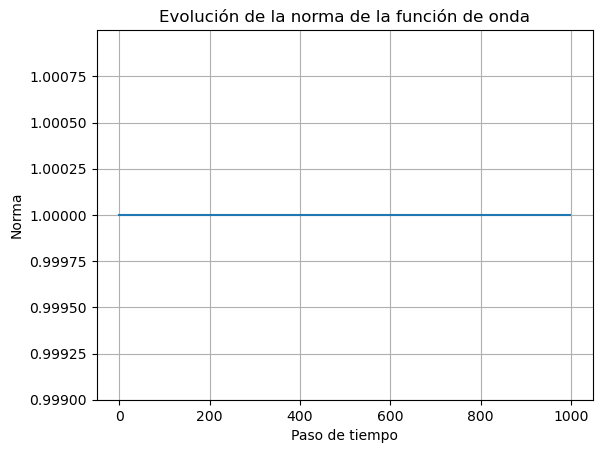

In [25]:
# Graficar la norma con ajustes de escala
fig, ax = plt.subplots()
ax.plot(np.arange(pasos), norma_instantes)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.5f}"))
ymin = norma_instantes.min() * 0.999
ymax = norma_instantes.max() * 1.001
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Paso de tiempo')
ax.set_ylabel('Norma')
ax.set_title('Evolución de la norma de la función de onda')
ax.grid(True)
plt.show()

### Resultados

El objetivo principal de este ejercicio era resolver la ecuación de Schrodinger para el potencial cuadrado. Se puede comprobar que el algoritmo ha cumplido satisfactoriamente su cometido al calcular las amplitudes de probabilidad de la función de onda a cada paso, ello, mediante representación de estos resultados en el archivo de video adjunto en este carpeta "schrodinger.mp4". En este, además de observar la onda se puede comprobar cómo, al interacionar con el potencial, una parte se transmite y otra se refleja, siendo este el comportamiento físico que se esperaba.

Por otro lado, destacar que hemos podido comprobar de nuevo el resultado al verificar que la norma es unitaria y constante en el tiempo.

Por último, a nivel de rendimiento, se ha comprobado que, con este equipo, el tiempo medio de ejecución ha sido de $8.5 \pm 0.1 s$, mientras que usando Joel el tiempo de ejecución se ha reducido drásticamente hasta los $2.19 \pm 0.01$. Esto seguramente se deba al mejor aprovechamiento de la optimización y la parelización, teniendo en cuenta que Joel tiene 48 hilos mientras este equipo tiene 16 hilos.